# Opimized spiking neural network architectures

## 1. Initial setup

In [84]:
import numpy as np
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
from module import *
data_rows = {
    "e":  {0: 0, 1: 0, 2: 0, 3: 1, 4: 1, 5: 1},
    "r":  {0: 0, 1: 0, 2: 1, 3: 1, 4: 1, 5: 0},
    "c":  {0: 0, 1: 1, 2: 0, 3: 1, 4: 0, 5: 1},
    "cr": {0: 0, 1: 1, 2: 1, 3: 1, 4: 0, 5: 0},
    "l":  {0: 1, 1: 0, 2: 0, 3: 0, 4: 1, 5: 1},
    "lr": {0: 1, 1: 0, 2: 1, 3: 0, 4: 1, 5: 0},
    "lc": {0: 1, 1: 1, 2: 0, 3: 0, 4: 0, 5: 1},
    "f":  {0: 1, 1: 1, 2: 1, 3: 0, 4: 0, 5: 0},
    "off":{0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0}
}
numbers_2l = {
    0: "f lr lr lr f",
    1: "c c c c c",
    2: "f r f l f",
    3: "f r f r f",
    4: "lr lr f r r",
    5: "f l f r f",
    6: "f l f lr f",
    7: "f r r r r",
    8: "f lr f lr f",
    9: "f lr f r f",
}
numbers_d = {
    0: "f lr lr lr lr lr f",
    1: "c c c c c c c",
    2: "f r r c l l f",
    3: "lc r r c r r lc",
    4: "lr lr lr f r r r",
    5: "f l l c r r f",
    6: "f l l f lr lr f",
    7: "f r r c c c c",
    8: "c lr lr c lr lr f",
    9: "c lr lr cr r c l",
}
empty = np.array([[0,0,0,1,1,1],[0,0,0,1,1,1],[0,0,0,1,1,1],[0,0,0,1,1,1],[0,0,0,1,1,1]])

numbers_rows_2l = {k: [data_rows[vv] for vv in v.split(" ")] for k, v in numbers_2l.items()}
numbers_rows_d = {k: [data_rows[vv] for vv in v.split(" ")] for k, v in numbers_d.items()}

from ipywidgets import SelectMultiple, Select, Button, HBox, VBox, Output, IntRangeSlider, Checkbox, Accordion
def ui(data):
    def update_graph(b):
        fig, ax = plt.subplots(figsize=(8,8))
        s = np.concatenate(([x.value for x in select_nodes]))
        if np.isin('---', s):
            s = s[np.where(s != '---')].astype(int)
        for n in s:
            t = data.index.tolist()
            ax.step(t[xw.value[0]:xw.value[1]], data[n][xw.value[0]:xw.value[1]])
        ax.legend([int(n) for n in s])
        with graph:
            graph.clear_output()
            display(plt.show())


    graph = Output()
    layer_select = Select(
        options=net.nodes.layer.unique(),
        value=0,
        description='Слой'
    )

    type_chboxs = []
    for t in net.nodes.type.unique():
        type_chboxs.append(Checkbox(
            value=True,
            description=t,
            disabled=False
        ))
    select_nodes = []
    for t in type_chboxs:
        v = t.value
        if v:
            select_nodes.append(
                SelectMultiple(
                    options=np.insert(np.array(net.nodes.query(f"type=='{t.description}'").index.tolist(),dtype=object), 0, '---'),
                    description=t.description
                )
            )
            select_nodes[-1].rows = min(len(select_nodes[-1].options), 10)

    def on_layer_change(change):
        select_nodes = []
        for t in type_chboxs:
            v = t.value
            if v:
                select_nodes.append(
                    SelectMultiple(
                        options=np.insert(np.array(net.nodes.query(f"type=={t.description}").index.tolist(),dtype=object), 0, '---'),
                        description=t.description
                    )
                )
                select_nodes[-1].rows = min(len(select_nodes[-1].options), 10)

    layer_select.observe(on_layer_change, names='value')

    xw = IntRangeSlider(
        min=data.index.min(),
        max=data.index.max(),
        value=(data.index.min(), data.index.max()),
        description='Окно просмотра',
        disabled=False
    )
    select = Accordion(children=[VBox(type_chboxs), VBox(select_nodes)])
    select.selected_index=1
    select.set_title(0, 'Типы')
    select.set_title(1, 'Ноды')
    xw.observe(update_graph, names='value')
    [x.observe(update_graph, names='value') for x in select_nodes]
    draw = Button(description='Draw')
    draw.on_click(update_graph)
    return HBox((VBox((xw,select,draw)), graph))


def calculate_aggregate_error(network_error):
    e = {k: v.copy() for k, v in network_error.items()}
    mins = []
    for _ in network_error.keys():
        b = {k: min(e[k], key=lambda x: abs(e[k][x])) for k in e.keys()}
        a = min(b, key=lambda x: abs(e[x][b[x]]))
        mins.append(e[a][b[a]])
        del e[a]
        for k in e.keys():
            del e[k][b[a]]
    mins = np.array(mins)
    return mins.mean()

## 2. 2 layer SNN

## 3. Dendritic SNN

### 3.1. Network generation preset

In [68]:
def new_network(p={}):
    params = params_dendrites.copy()
    params.update(p)
    net = SpikeNetworkSim(inputs_l=6, dt=1)
    teacher_nodes, who_is_who = net.ttron_layer(num_nodes=4, num_cat_inputs=4, delay_depth=5, **params)
    return net, teacher_nodes, who_is_who
net, teacher_nodes, who_is_who = new_network()

### 3.2. Training and test data generation

In [9]:
row_time = 10
silent_time = 100

genome = {
    1:{35:0, 65:0}, 
    2:{35:1, 65:2},
    3:{35:1, 65:1}, 
    4:{35:3, 65:1}, 
    5:{35:2, 65:1},
    6:{35:2, 65:3},
    7:{35:1, 65:0}, 
}
pattern_sights = {teacher_nodes[k]: (np.concatenate([(g[row_time*3.5], g[row_time*6.5]) for g in genome.values()])==k).sum() for k in range(4)}

#### 3.2.1. Training data

In [14]:
def gen_training_set(n_num):
    seq_data = []
    seq_labels = []
    a = None
    for n in range(n_num):
            a = np.random.randint(1, 8)
            seq_data+=[x.copy() for x in numbers_rows_d[a]]
            seq_labels+=[a for _ in numbers_rows_d[a]]
            seq_labels.append(-1)
            seq_data.append(data_rows["off"].copy())

    nseq_d = []
    nseq_l = []

    for d, l in zip(seq_data, seq_labels):
        if l != -1:
            t = row_time
        else:
            t = silent_time
        nseq_d.append(d.copy())
        nseq_l.append(l)
        for i in range(t-1):
            nseq_d.append(data_rows["off"].copy())
            nseq_l.append(l)

    seq_data = nseq_d
    seq_labels = nseq_l

    d_p = seq_labels[0]
    step = 1
    for i, d in enumerate(seq_labels[1:]):
        seq_data[i].update({k:0 for k in teacher_nodes})
        if d_p == -1 and d != d_p:
            step = 0
        if d in genome:
            if step in genome[d]:
                seq_data[i][teacher_nodes[genome[d][step]]] = 1
        d_p = d
        step += 1
    return seq_data

#### 3.2.2. Test data

In [13]:
nseq_d = []
nseq_l = []
test_data = []
test_labels = []
a = None
for n in range(1, 9):
    a = n
    test_data+=[x.copy() for x in numbers_rows_d[a]]
    test_labels+=[a for _ in numbers_rows_d[a]]
    test_labels.append(-1)
    test_data.append(data_rows["off"].copy())

for d, l in zip(test_data, test_labels):
    if l != -1:
        t = row_time
    else:
        t = silent_time
        
    nseq_d.append(d.copy())
    nseq_l.append(l)
    for i in range(t-1):
        nseq_d.append(data_rows["off"].copy())
        nseq_l.append(l)

test_data = nseq_d
test_labels = nseq_l
step = 0
d_p = 0
for i, d in enumerate(test_labels[1:]):
    test_data[i].update({k:0 for k in teacher_nodes})
    if d_p == -1 and d != d_p:
        step = 0
    if d in genome:
        if step<25:
            test_data[i][teacher_nodes[genome[d][35]]] = 1
        elif step<35:
            test_data[i][teacher_nodes[genome[d][35]]] = 1
            test_data[i][teacher_nodes[genome[d][65]]] = 1     
        else:
            test_data[i][teacher_nodes[genome[d][65]]] = 1            
    d_p = d
    step += 1

### 3.3. Hyperparameter optimization

In [25]:
POOL_N = 5
HYPER_POOL = 5
error_convolution_threshold = 1.2

In [ ]:
networks_pool = []
variations = []
net, _, _ = new_network()
start_weights = net.weights.weights.copy()
temp_start = temp = 0.5
training_data = [gen_training_set(10) for _ in range(10)]
params_dendrites = {
    "tau_leak": 2*row_time, 
    "tau_inhibitory": 1,
    "tau_refractory": 1,
    "tau_ltp": 3*row_time, 
    "thres": 1150,
    "ainc": 0.7, 
    "adec": -3, 
    "wmax": 250, 
    "wmin": 1,
    "learning": True,
    "wta": True,
    "layer_type": "ttron"
}


for i in tqdm(range(HYPER_POOL)):
    for j in tqdm(range(POOL_N)):
        params_update = {
            "tau_leak": np.random.randint(-1*row_time, 1*row_time)*temp+params_dendrites["tau_leak"]*(1-temp), 
            "tau_ltp": np.random.randint(-1*row_time, 1*row_time)*temp+params_dendrites["tau_ltp"]*(1-temp), 
            "wmax": np.random.randint(params_dendrites["wmin"]+1, 255)*temp+params_dendrites["wmax"]*(1-temp), 
        }
        params_update = {k: v if v > 0 else 1 for k, v in params_update.items()}
        net, _, _ = new_network(params_update)
        net.weights.weights = start_weights.copy()
        error_agg = error_agg_min = 1
        for section, training_data_part in enumerate(training_data):
            net.layer_params["learning"][-1] = True
            out_learn = net.feed_raw(training_data_part)
            net.layer_params["learning"][-1] = False
            out_test = net.feed_raw(test_data)

            error_agg = calculate_aggregate_error(net.error(teacher_nodes, pattern_sights=pattern_sights))

            if error_agg > error_agg_min*error_convolution_threshold:
                break
                
            if error_agg < error_agg_min:
                params_dendrites.update(params_update)
                temp = temp_start*error_agg_min
                
            error_agg_min = min(error_agg, error_agg_min)
            variations.append(
                {"sp": i*HYPER_POOL+j, "sec": section, "weights": net.weights.weights.copy(), "error_agg": error_agg, "params_update": params_update.copy()}
            )
    
optimization_ds = pd.DataFrame(variations)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

0      {'tau_leak': 13.0, 'tau_ltp': 16.5, 'wmax': 17...
136    {'tau_leak': 15.822916666666668, 'tau_ltp': 9....
137    {'tau_leak': 15.822916666666668, 'tau_ltp': 9....
1      {'tau_leak': 13.0, 'tau_ltp': 16.5, 'wmax': 17...
138    {'tau_leak': 15.822916666666668, 'tau_ltp': 9....
Name: params_update, dtype: object


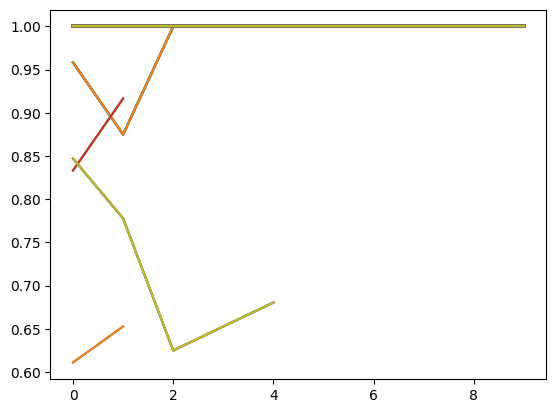

In [88]:
for i in optimization_ds.sp:
    d = optimization_ds.sort_values("sec").groupby("sp", group_keys=True).apply(pd.DataFrame).loc[i]
    plt.plot(
        d.sec, 
        d.error_agg
    )
print(optimization_ds.loc[optimization_ds["error_agg"].abs().sort_values().index[:5]].params_update)